## Chapter 2-3, 2-1강 시계열 예측 모델링 — Classical & Baselines (Bike Sharing)

- **목표**: 회귀(선형/랜덤포레스트), 시계열 전용(SARIMA/Prophet) 모델을 단계별로 학습·평가하여 비교합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn X), 색상 지정 X, 서브플롯 X


#### 강의 개요 및 학습 목표
- 시계열 예측의 중요성과 활용: 수요/재고/인력/교통/에너지 등
- 일반 회귀 vs 시계열 모델 차이: IID 가정 vs 자기상관/계절성/추세
- 실습을 통한 모델 성능 비교 학습 및 해석


### 0. 환경 준비 및 라이브러리 임포트

- 시각화는 `matplotlib`만 사용합니다.
- 회귀 모델(`scikit-learn`), 시계열(`statsmodels`), Prophet(선택)을 사용합니다.
- 한글 폰트와 경고 억제를 설정합니다.


In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
    _HAS_PROPHET = True
except Exception:
    _HAS_PROPHET = False

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정
import matplotlib
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = [
    "AppleGothic","NanumGothic","Malgun Gothic","Noto Sans CJK KR","Noto Sans KR","DejaVu Sans"
]
matplotlib.rcParams["axes.unicode_minus"] = False

pd.set_option('display.max_columns', 100)


Importing plotly failed. Interactive plots will not work.


### 1. 데이터 준비 및 전처리
- `bike-sharing-demand/train.csv` 로드, `datetime` 파싱/정렬
- 시간 파생변수 생성(년/월/일/요일/시간)
- 시간 순서대로 train/val/test 분할


In [2]:
def load_hourly_data():
    path = 'bike-sharing-demand/train.csv'
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv 경로를 찾을 수 없습니다.')
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    cols = ['datetime','season','holiday','workingday','weather','temp','atemp','humidity','windspeed','casual','registered','count']
    return df[cols]


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['year'] = out['datetime'].dt.year
    out['month'] = out['datetime'].dt.month
    out['day'] = out['datetime'].dt.day
    out['dayofweek'] = out['datetime'].dt.dayofweek
    out['hour'] = out['datetime'].dt.hour
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test


df = load_hourly_data()
print('데이터 크기:', df.shape, '기간:', df['datetime'].min(), '→', df['datetime'].max())
df_feat = add_time_features(df)
train_df, val_df, test_df = split_by_time(df_feat)


데이터 크기: (10886, 12) 기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00


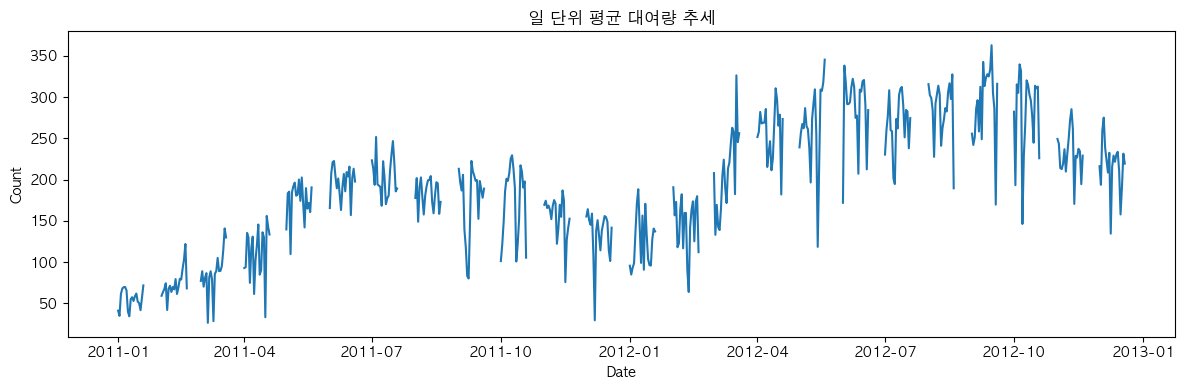

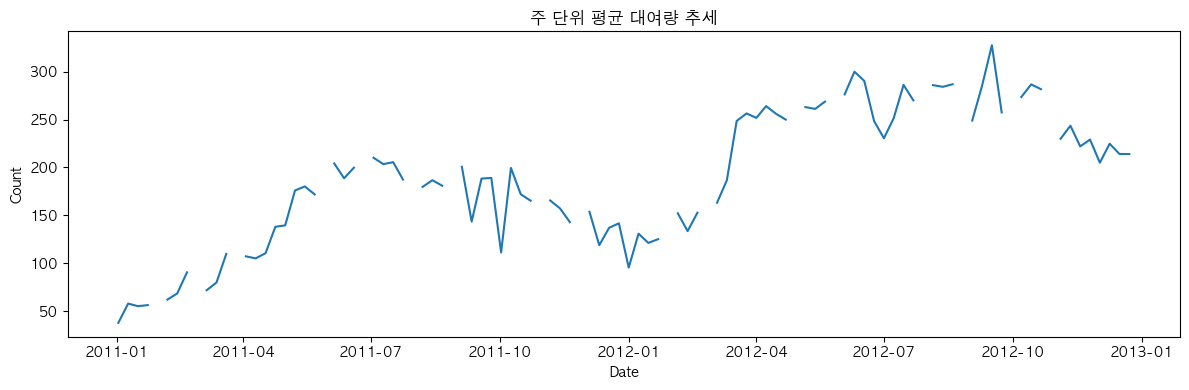

In [5]:
# 시계열 인덱스 설정
_df = df.set_index('datetime')

# 집계 및 시각화 함수
def resample_and_plot(series: pd.Series, rule: str, title: str) -> pd.Series:
    """
    시리즈를 주어진 규칙으로 집계(mean)하고 단일 선 그래프로 시각화합니다.
    Args:
        series: 시계열 Series (DatetimeIndex)
        rule: 리샘플 규칙('D','W' 등)
        title: 플롯 제목
    Returns:
        pd.Series: 리샘플된 평균 시리즈
    """
    agg = series.resample(rule).mean()
    plt.figure(figsize=(12,4))
    plt.plot(agg.index, agg.values)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    return agg

hourly = _df['count']
daily = resample_and_plot(hourly, 'D', '일 단위 평균 대여량 추세')
weekly = resample_and_plot(hourly, 'W', '주 단위 평균 대여량 추세')

### 2. 일반 회귀 베이스라인: 선형 회귀 vs 랜덤포레스트
- 입력: 시간 파생 + 기상/상태 변수, 타깃: `count`
- 평가: MAE/MSE/RMSE/MAPE, 방향정확도(DA)


### 3-1. 정상성 검정 및 ACF/PACF 분석
- ADF(정상성) 검정
- ACF/PACF 시각화로 (p,d,q)(P,D,Q,s) 가이드 얻기


ADF 통계량=-2.006, p-value=0.28399


<Figure size 1000x300 with 0 Axes>

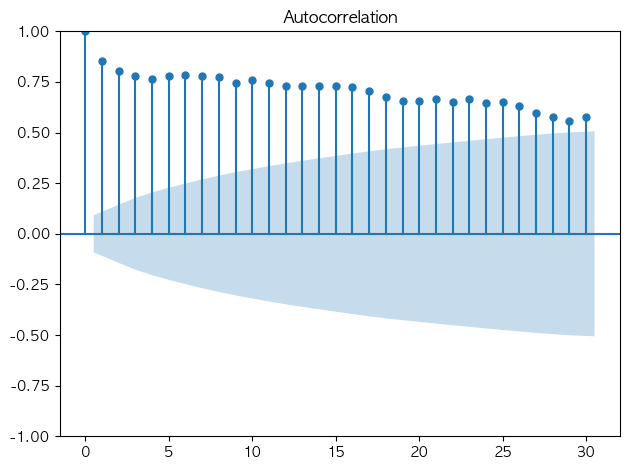

<Figure size 1000x300 with 0 Axes>

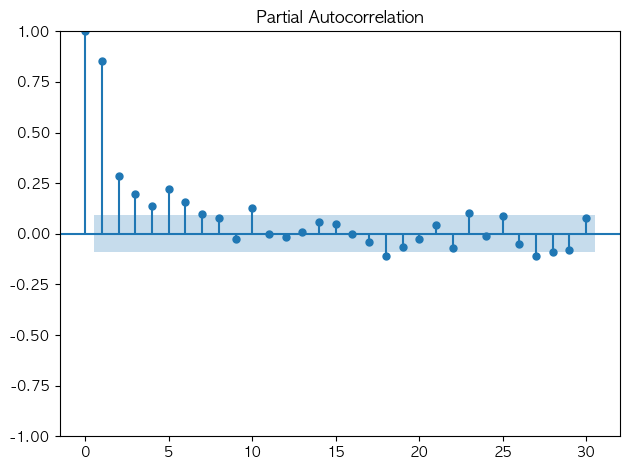

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

adf_stat, pval, *_ = adfuller(daily.dropna())
print(f'ADF 통계량={adf_stat:.3f}, p-value={pval:.5f}')
plt.figure(figsize=(10,3))
plot_acf(daily.dropna(), lags=30)
plt.tight_layout(); plt.show()
plt.figure(figsize=(10,3))
plot_pacf(daily.dropna(), lags=30)
plt.tight_layout(); plt.show()


Linear/VAL (112.4611565998219, 21701.57246647914, 147.3145358288826, 211.8003825249917, 0.6663602941176471)
Linear/TEST (84.4124170104707, 12720.204474477754, 112.78388393062971, 204.5267033844516, 0.6431192660550459)


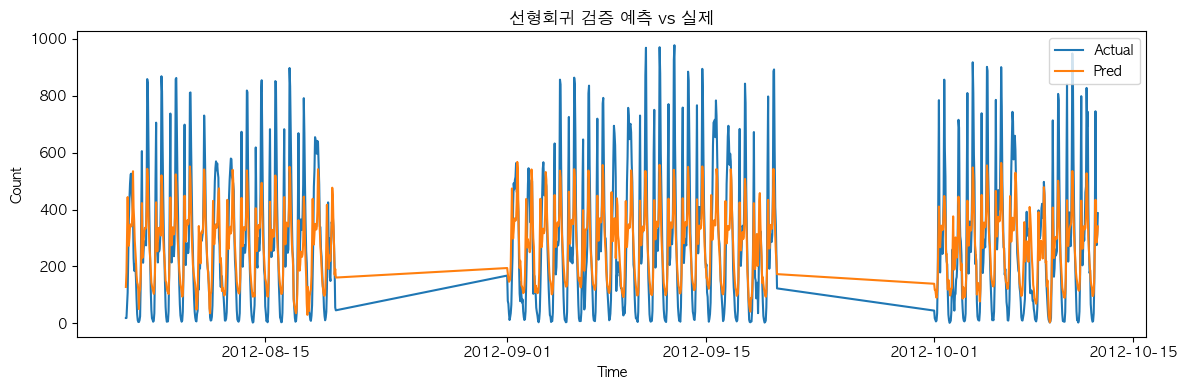

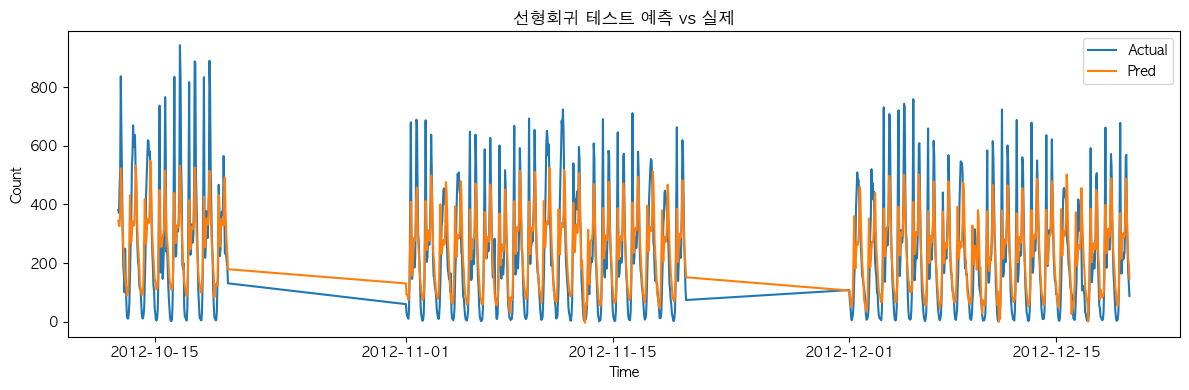

RF/VAL (59.31135723039216, 8326.449294475082, 91.2493796936455, 32.91031953405568, 0.8391544117647058)
RF/TEST (68.76297553516821, 10117.330518318044, 100.58494180700232, 38.524097408255706, 0.7706422018348624)


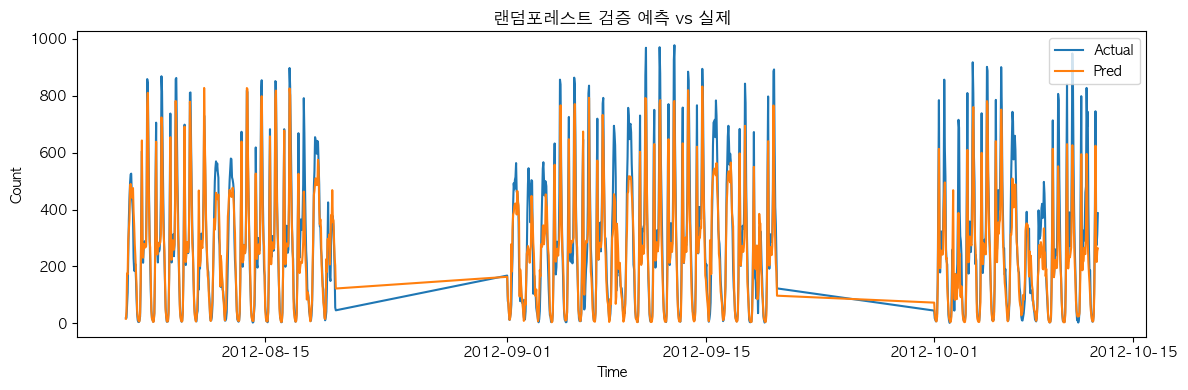

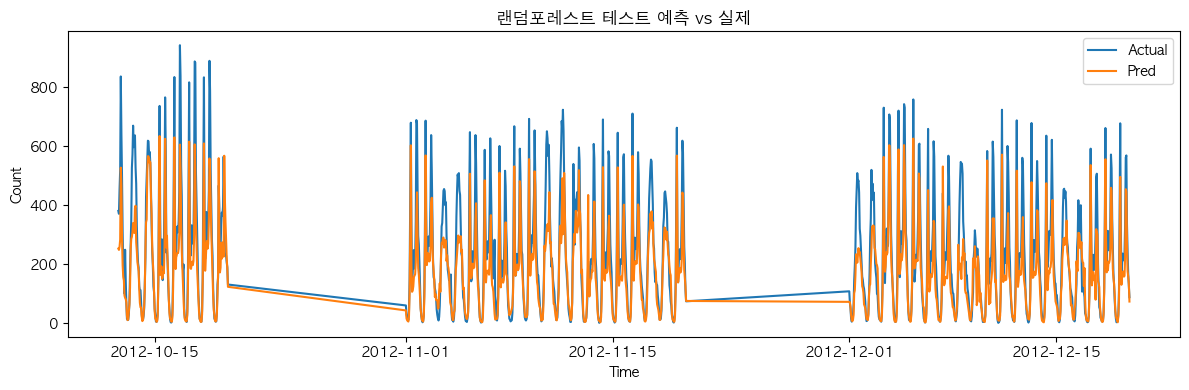

RF 중요도 TOP 15:
 atemp           0.186645
hour_17         0.094062
humidity        0.084904
hour_18         0.079720
hour_8          0.055163
workingday_0    0.047907
workingday_1    0.047481
temp            0.041277
year_2011       0.030997
year_2012       0.030407
hour_19         0.030261
hour_7          0.016440
hour_2          0.015388
hour_1          0.015234
day             0.014464
dtype: float64


In [8]:
def to_supervised_features(df: pd.DataFrame, target: str = 'count'):
    feature_cols = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','year','month','day','dayofweek','hour']
    X = df[feature_cols].copy()
    X = pd.get_dummies(X, columns=['season','holiday','workingday','weather','year','month','dayofweek','hour'], drop_first=False)
    y = df[target].astype(float)
    return X, y


def compute_metrics(y_true, y_pred):
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    prev = np.concatenate([[y_true[0]], y_true[:-1]])
    da = float(np.mean((np.sign(y_true - prev) == np.sign(y_pred - prev)).astype(float)))
    return mae, mse, rmse, mape, da


def plot_actual_vs_pred(dt_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 분할별 특징 생성
X_train, y_train = to_supervised_features(train_df)
X_val, y_val     = to_supervised_features(val_df)
X_test, y_test   = to_supervised_features(test_df)

# 학습 컬럼에 맞춰 정렬/보정 (없는 컬럼은 0 채움)
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(X_train, y_train)
lin_val_pred  = lin.predict(X_val)
lin_test_pred = lin.predict(X_test)

print('Linear/VAL', compute_metrics(y_val.to_numpy(), lin_val_pred))
print('Linear/TEST', compute_metrics(y_test.to_numpy(), lin_test_pred))
plot_actual_vs_pred(val_df['datetime'].values, y_val.to_numpy(), lin_val_pred, '선형회귀 검증 예측 vs 실제')
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), lin_test_pred, '선형회귀 테스트 예측 vs 실제')

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)
print('RF/VAL', compute_metrics(y_val.to_numpy(), rf_val_pred))
print('RF/TEST', compute_metrics(y_test.to_numpy(), rf_test_pred))
plot_actual_vs_pred(val_df['datetime'].values, y_val.to_numpy(), rf_val_pred, '랜덤포레스트 검증 예측 vs 실제')
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), rf_test_pred, '랜덤포레스트 테스트 예측 vs 실제')

try:
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print('RF 중요도 TOP 15:\n', importances.head(15))
except Exception:
    pass


### 5. 하이퍼파라미터 최적화 & 시계열 교차검증
- `TimeSeriesSplit`을 이용한 교차검증
- 랜덤포레스트 간단 Grid Search


In [9]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

X_all, y_all = to_supervised_features(df_feat)

tscv = TimeSeriesSplit(n_splits=5)
params = {"n_estimators": [200, 300], "max_depth": [None, 12, 24]}
rf_gs = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_gs.fit(X_all, y_all)
print('최적 하이퍼파라미터:', rf_gs.best_params_)
print('CV RMSE:', -rf_gs.best_score_)


최적 하이퍼파라미터: {'max_depth': None, 'n_estimators': 300}
CV RMSE: 101.34451195673624


### 6. 앙상블 모델링 (가중 평균)
- 선형회귀와 랜덤포레스트의 검증 예측을 가중 평균
- 검증 성능으로 가중치 선택 후 테스트 평가


검증기반 최적 가중치 w=0.00, RMSE=91.249
Ensemble(TEST) (68.76297553516821, 10117.330518318044, 100.58494180700232, 38.524097408255706, 0.7706422018348624)


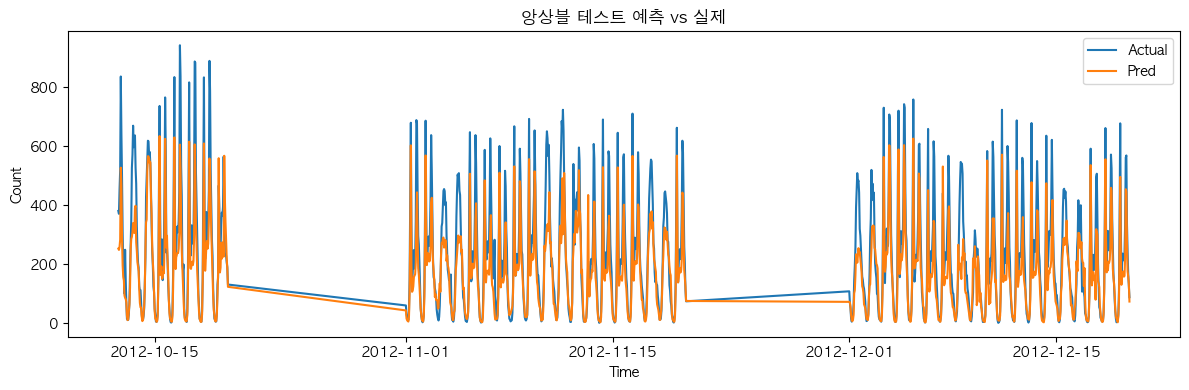

In [11]:
def weighted_ensemble(y1, y2, w):
    return w*y1 + (1-w)*y2

best_w, best_rmse = None, float('inf')
for w in np.linspace(0,1,11):
    ens = weighted_ensemble(lin_val_pred, rf_val_pred, w)
    _, _, rmse, _, _ = compute_metrics(y_val.to_numpy(), ens)
    if rmse < best_rmse:
        best_rmse = rmse
        best_w = w
print(f'검증기반 최적 가중치 w={best_w:.2f}, RMSE={best_rmse:.3f}')

ens_test = weighted_ensemble(lin_test_pred, rf_test_pred, best_w)
print('Ensemble(TEST)', compute_metrics(y_test.to_numpy(), ens_test))
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), ens_test, '앙상블 테스트 예측 vs 실제')


### 7. 잔차 분석
- 테스트 구간 잔차 시각화 및 분포 확인
- 패턴/이분산/비정상성 여부 점검


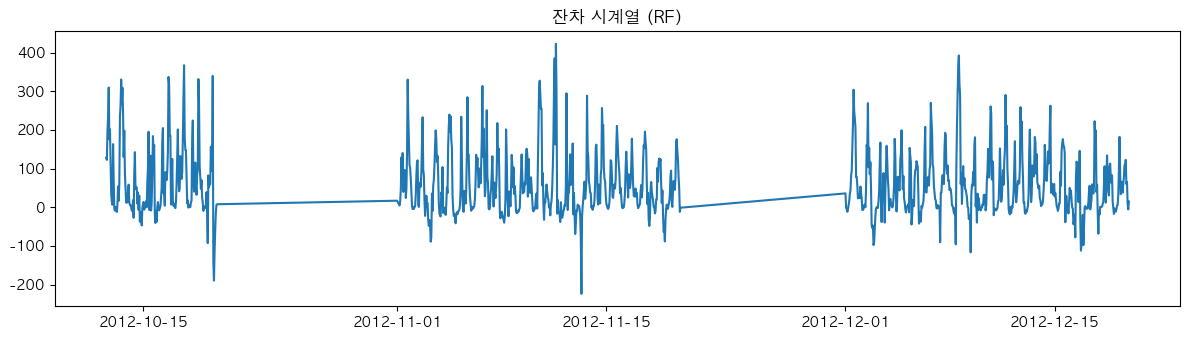

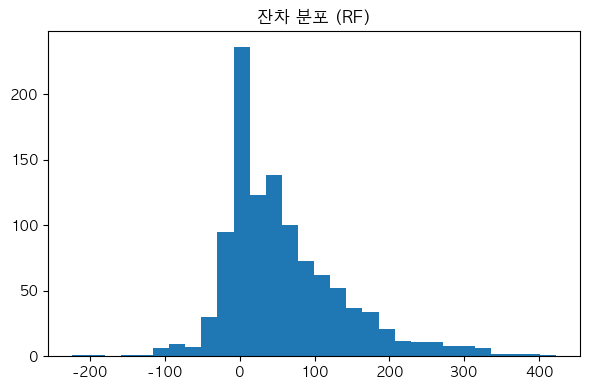

In [12]:
residual = y_test.to_numpy() - rf_test_pred
plt.figure(figsize=(12,3.5))
plt.plot(test_df['datetime'].values, residual)
plt.title('잔차 시계열 (RF)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('잔차 분포 (RF)')
plt.tight_layout(); plt.show()


### 8. 강의 요약 및 다음 단계
- 모델별 지표 비교 및 해석 정리
- 시계열 특성(계절/추세/자기상관)을 반영한 모델 선택 가이드
- 다음 강의: LSTM/딥러닝 확장 및 하이브리드/앙상블 고도화


### 3. 시계열 전용 모델: SARIMA, Prophet(선택)
- 일 단위 평균으로 집계 후 예측
- SARIMA 기본 파라미터로 시연, Prophet은 설치 시 실행


SARIMA/VAL (36.91510622639695, 2645.8391011410713, 51.4377206060015, 16.206434479844432, 0.5774647887323944)
SARIMA/TEST (49.68640046105371, 3041.212785200105, 55.14719199741819, 22.738227062225928, 0.5616438356164384)


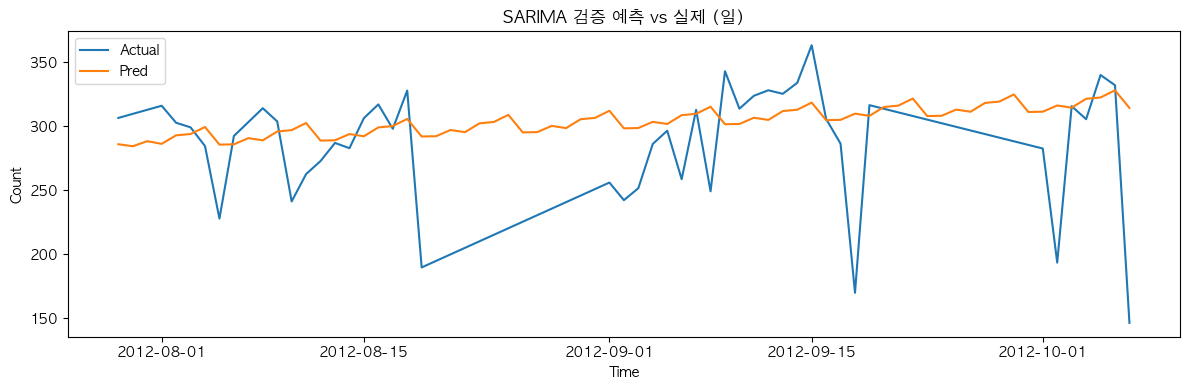

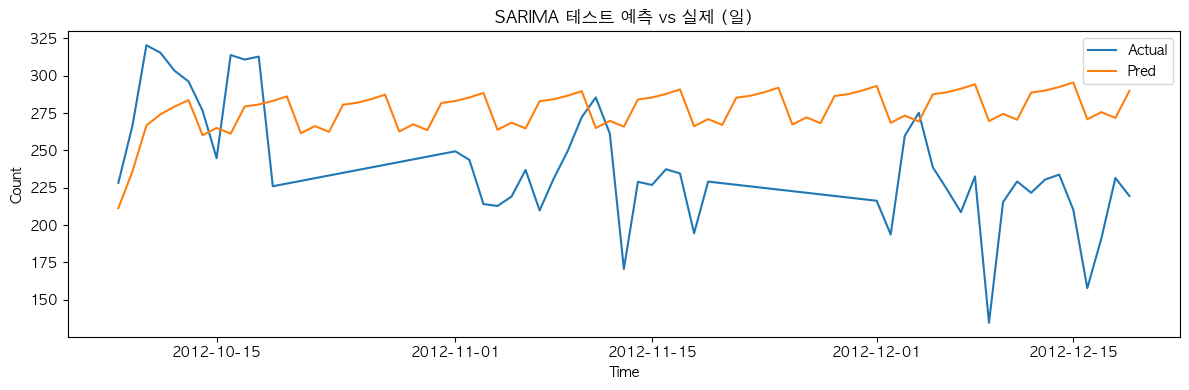

21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet/VAL (55.136593561391784, 5054.311634076586, 71.09368209676994, 23.64554462388265, 0.5352112676056338)


In [16]:
def aggregate_daily(df: pd.DataFrame) -> pd.Series:
    return df.set_index('datetime')['count'].resample('D').mean()


daily = aggregate_daily(df)
daily = daily.asfreq('D').interpolate().ffill().bfill()
N = len(daily)
N_tr, N_va = int(N*0.8), int(N*0.1)
daily_tr = daily.iloc[:N_tr]
daily_va = daily.iloc[N_tr:N_tr+N_va]
daily_te = daily.iloc[N_tr+N_va:]

sar = SARIMAX(daily_tr, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
va_fc = sar.forecast(steps=len(daily_va)).to_numpy()
combined = pd.concat([daily_tr, daily_va])
#te_fc = SARIMAX(daily_tr.append(daily_va), order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(daily_te)).to_numpy()
te_fc = (
    SARIMAX(combined, order=(1,1,1), seasonal_order=(1,1,1,7),
            enforce_stationarity=False, enforce_invertibility=False)
    .fit(disp=False)
    .forecast(steps=len(daily_te))
    .to_numpy()
)
print('SARIMA/VAL', compute_metrics(daily_va.to_numpy(), va_fc))
print('SARIMA/TEST', compute_metrics(daily_te.to_numpy(), te_fc))
plot_actual_vs_pred(daily_va.index, daily_va.to_numpy(), va_fc, 'SARIMA 검증 예측 vs 실제 (일)')
plot_actual_vs_pred(daily_te.index, daily_te.to_numpy(), te_fc, 'SARIMA 테스트 예측 vs 실제 (일)')

if _HAS_PROPHET:
    dprop = pd.DataFrame({'ds': daily_tr.index, 'y': daily_tr.values})
    m = Prophet(seasonality_mode='additive', weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
    m.fit(dprop)
    future = pd.DataFrame({'ds': pd.date_range(start=daily_tr.index[-1] + pd.Timedelta(days=1), periods=len(daily_va), freq='D')})
    yhat_val = m.predict(future)['yhat'].to_numpy()
    print('Prophet/VAL', compute_metrics(daily_va.to_numpy(), yhat_val))
else:
    print('Prophet 미설치: 건너뜀')


### 4. 성능 비교 요약
- MAE, MSE, RMSE, MAPE, 방향정확도(DA) 지표 비교
- 모델별 예측 vs 실제 시각화로 패턴 비교


## 추가: 베이스라인(Naive/Seasonal Naive) & 워크포워드 평가

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return {'MAE': round(mae, 3), 'RMSE': round(rmse, 3)}

def naive_forecast(y_train, horizon):
    return np.repeat(y_train[-1], horizon)

def seasonal_naive_forecast(y_train, horizon, season=7):
    last_season = y_train[-season:]
    reps = int(np.ceil(horizon/season))
    return np.tile(last_season, reps)[:horizon]


In [ ]:
# 검증/테스트 구간 베이스라인 성능 비교
y_tr, y_va, y_te = daily_tr.to_numpy(), daily_va.to_numpy(), daily_te.to_numpy()
h_va, h_te = len(y_va), len(y_te)
yhat_va_naive   = naive_forecast(y_tr, h_va)
yhat_va_snaive  = seasonal_naive_forecast(y_tr, h_va, season=7)
yhat_te_naive   = naive_forecast(np.concatenate([y_tr, y_va]), h_te)
yhat_te_snaive  = seasonal_naive_forecast(np.concatenate([y_tr, y_va]), h_te, season=7)
print('Naive/VAL ', metrics(y_va, yhat_va_naive))
print('SNaive/VAL', metrics(y_va, yhat_va_snaive))
print('Naive/TEST ', metrics(y_te, yhat_te_naive))
print('SNaive/TEST', metrics(y_te, yhat_te_snaive))


In [ ]:
# 워크포워드(확장 윈도우) 평가 스켈레톤: SARIMA & 베이스라인 비교
from statsmodels.tsa.statespace.sarimax import SARIMAX
def rolling_eval(series: pd.Series, init_len: int, horizon: int = 7, step: int = 7):
    rmses = {'Naive': [], 'SNaive': [], 'SARIMA': []}
    i = init_len
    y = series.to_numpy()
    while i + horizon <= len(y):
        y_tr = y[:i]
        y_true = y[i:i+horizon]
        # baselines
        yhat_n = naive_forecast(y_tr, horizon)
        yhat_s = seasonal_naive_forecast(y_tr, horizon, season=7)
        # SARIMA (주요 노트북과 동일 파라미터)
        try:
            m = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
            res = m.fit(disp=False)
            yhat_a = res.forecast(steps=horizon)
        except Exception:
            yhat_a = np.repeat(y_tr[-1], horizon)
        # scores
        rmses['Naive'].append(sqrt(mean_squared_error(y_true, yhat_n)))
        rmses['SNaive'].append(sqrt(mean_squared_error(y_true, yhat_s)))
        rmses['SARIMA'].append(sqrt(mean_squared_error(y_true, yhat_a)))
        i += step
    return {k: float(np.mean(v)) if v else np.nan for k, v in rmses.items()}

series_cv = pd.concat([daily_tr, daily_va])
cv_scores = rolling_eval(series_cv, init_len=len(daily_tr), horizon=7, step=7)
print('워크포워드 평균 RMSE (7일 horizon):', {k: round(v,3) for k,v in cv_scores.items()})
